# Clasificador de Noticias

En esta notebook se detalla la creación de un clasificador de noticias que utiliza el set de datos "fetch_20newsgroups" de la librería Sklearn.

Dicho clasificador utiliza un clasificador Naive Bayer con Smoothing Laplaciano, preprocesando el texto mediante Tokenizado, Lematizado, eliminación de Stopwords, Estemizado y un Filtrado de palabras no alfabéticas.

A su vez utiliza CountVectorizer y TFIDF para la vectorización y realiza una comparativa final entre ambas opciones en cuanto al Accuracy que permite cada opción. 

In [2]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns

---
## Importación de los sets de train y test.
Se eliminan los headers y los footers.
Se verifican los tamaños de los sets y las categorías a las que corresponden los artículos.

In [2]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'footers'))
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, remove=('headers', 'footers'))
print('Length train: '+ str(len(twenty_train.data)))
print('Length test: '+ str(len(twenty_test.data)))

print(twenty_train.target_names)

Length train: 11314
Length test: 7532
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
# A fin de analizar el formato de los artículos, se imprimen los primeros 5.
for i in range(5):
    print('NEW DATA')
    print(twenty_train.data[i])

NEW DATA
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
NEW DATA
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't ans

---
## Balance de Clases

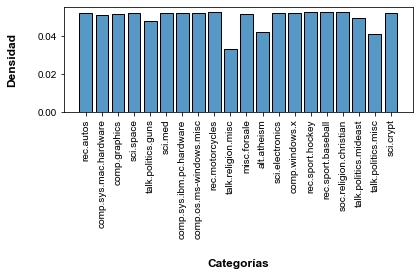

In [4]:
np_target_names = np.array(twenty_train.target_names)
np_target = np.array(twenty_train.target)
hist = sns.histplot(np_target_names[np_target],stat="density", discrete=True, shrink=.8)
sns.set(rc={'figure.figsize':(10,5)})
plt.xticks(rotation=90);
hist.set_xlabel("Categorías", labelpad=20, weight='bold', size=12)
hist.set_ylabel("Densidad", labelpad=20, weight='bold', size=12)
plt.tight_layout()

---
## Preprocesamiento.

Antes de alimentar al modelo con los textos, es necesario transformarlos a fin de aumentar la consistencia de la métrica a obtener. Para ello se siguen una serie de pasos que se explican a continuación,.

### Tokenización
La tokenización es el proceso por el cual una gran cantidad de texto se divide en partes más pequeñas llamadas tokens. Los tokens serán utilizados para posteriormente procesar individualmente cada palabra del texto.
### Lematización
La lematización tiene en cuenta el análisis morfológico de las palabras para transformarlas. Distintas palabras que corresponden a un mismo concepto pero varían levemente -o no varían- en su significado son llevadas a una forma en común que las representa a todas. En general esta forma coincide con el formato de las palabras que se encuentran en el diccionario. Por ejemplo, los verbos son transformados en sus infinitivos y los plurales en singulares.
### Stopwords
Las "stopwords" son las palabras comunes más comunes en un idioma. Por esta razón, tenerlas en cuenta para el modelo que se desea implementar no aporta información relevante en cuanto a la categorización de los textos e implica mayor tiempo de procesamiento. Como ejemplo las palabras "a", "de", "y", "el" y "o" son consideradas stopwords en el idioma español.
### Estemizado
El estemizado reduce las palabras a su raíz y es utilizado en el preprocesamiento del texto con el objetivo de unificar términos cuyos sufijos varían pero pertenecen a las mismas clases. Por ejemplo, las palabras "niños" y "niñez" podrían ser reducidas mediante esta técnica a la raíz "niñ".
### Filtrado de no alfabéticos.
Una vez aplicadas las técnicas mencionadas anteriormente, es probable que el vocabulario siga contando con tokens que no sean palabras. Estos tokens, como signos de puntuación o números, no aportan información útil al procesamiento por lo tanto deben ser eliminados para mejorar el rendimiento del modelo.

### NLTK
La librería NLTK (Natural Language Toolkit) contiene herramientas y paquetes con funcionalidades relacionadas al procesamiento estadístico del lenguaje natural. Entre estas herramientas se encuentran las explicadas anteriormente (lematización, estemizado, etc.).

#### Selección del Stemmer
Los tres principales algoritmos de stemming que se utilizan son: Porter Stemmer, Snowball Stemmer y Lancaster Stemmer. 
 
El algoritmo de Porter es el más antiguo de los tres algoritmos mencionados y es el menos "agresivo". A su vez, implica un alto costo en términos de tiempo de procesamiento. Por su parte, el algoritmo Snowball presenta algunas mejoras con respecto al de Porter y en cuanto a tiempo de procesamiento es algo mas rápido. Por último, el algoritmo de Lancaster es el más rapido de los tres pero el resultado del lematizado es poco intuitivo y de difícil análisis.  
Analizando los beneficios y contras de cada stemmer, decidimos utilizar el ***Snowball Stemmer***, provisto por NLTK. 

#### Selección del Lematizador
***Wordnet*** es una base de datos léxica que proporciona relaciones semánticas entre sus palabras. Wordnet agrupa distintos elementos de datos que son semánticamente equivalentes en "synsets". Es una de las primeras y más utilizadas técnicas de lematización y se encuentra disponible con NLTK. Por estas razones, decidimos utilizar dicho lematizador.  

Sin embargo, este lematizador trata por defecto a todas las palabras como si fueran sustantivos. Así, muchos verbos se mantienen iguales luego de la lematización. Para solucionar este problema, es necesario utilizar etiquetas "***POS***" (Part Of Speech). Por cada palabra, se llama al lematizador con una etiqueta que define su tipo (adjetivo, sustantivo, verbo, etc.). 

 

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') #For POS tags

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
# Inicialización del lematizador y del stemmer.
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [7]:
#Traduce etiquetas POS de la función nltk.pos_tag en etiquetas que acepta WordNetLemmatizer.
def pos_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [8]:
def pre_process_data(data_in):
    """
    Aplica a un set de datos de entrada: tokenización, lematización, filtrado de stopwords, estemizado y filtrado de no alfabéticos.
    Devuelve el set de datos filtrado.
    """
    filtered_arts = list()
    aux_porc = -1
    for i in range(len(data_in)):
        ############## TOKENIZE ################
        tokenized = word_tokenize(data_in[i])
        ############## LEMMATIZE ################
        pos_tagged = nltk.pos_tag(tokenized)
        wordnet_tagged = list(map(lambda x: (x[0], pos_tag_to_wordnet_tag(x[1])), pos_tagged))
        lemmatized = list()
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized.append(word)
            else:        
                lemmatized.append(lemmatizer.lemmatize(word, tag))
        ############## STOP WORDS ################
        stop = [lem for lem in lemmatized if lem not in stopwords.words('english')]
        ############## STEMMER ################
        stemmed=[stemmer.stem(w) for w in stop]
        ############## REMOVE NON ALPHA ################
        alpha = [st for st in stemmed if st.isalpha()]
        ############## JOIN ################
        filtered_arts.append(" ".join(alpha))
        ########## PRINT PROGRESS ############
        porc = int((i/len(data_in))*100)
        if (porc!=aux_porc):
            print(str("\rProcesado: " + str(porc) + "%"), end="")
            porc = aux_porc
    return filtered_arts


In [12]:
filteredArts = pre_process_data(twenty_train.data)

Procesado: 99%

In [4]:
import pickle
def save_preprocessed_data(file_name,pre_processed_data):
    '''Los datos se guardan en un archivo.'''
    with open(file_name, 'wb') as fp:
        pickle.dump(pre_processed_data, fp)
def load_preprocessed_data(file_name):
    '''Carga los datos de un archivo'''
    with open(file_name,'rb') as fp:
        return pickle.load(fp)

In [14]:
#Se guarda el resultado del preprocesamiento en un archivo mediante la librería Pickle.
save_preprocessed_data('art_filt.pkl', filteredArts)

In [15]:
#Se lee el resultado del preprocesamiento guardado en un archivo mediante la librería Pickle.
articlesList = load_preprocessed_data('art_filt.pkl')

In [16]:
#Se verifica que los artículos hayan sido obtenidos correctamente.
print(str(len(articlesList)))
print(articlesList[0])

11314
i wonder anyon could enlighten car i saw day it sport car look late earli it call bricklin the door realli small in addit front bumper separ rest bodi this i know if anyon tellm model name engin spec year product car make histori whatev info funki look car pleas


---
### Vectorización
Para el posterior análisis del vocabulario es importante conocer cuantas veces aparecen las palabras en los distintos artículos. Esto servirá para obtener los likelihoods de las categorías dependiendo de las palabras que aparezcan en un texto ingresado al modelo.  
A fin de realizar esta función se utiliza ***CountVectorizer***. Esta herramienta crea una matrix cuyas filas corresponden a cada uno de los artículos y sus columnas a cada palabra de nuestro vocabulario. Los valores de las "celdas" indican cuantas veces aparece cada palabra en cada artículo.  


A su vez, CountVectorizer recibe distintos parámetros, entre los que se encuentran *min_df* y *max_df*. El primero de estos indica un límite inferior de la cantidad de documentos (o porcentaje) en los que puede aparecer una palabra del vocabulario. Las palabras que aparezcan en un número menor de documentos a los que establece este límite serán descartadas por CountVectorizer. Estas son palabras que aparecen en una proporción muy pequeña de documentos y no aportan información útil al modelo. Por su parte, max_df establece un límite superior al porcentaje de documentos (o cantidad) en los que puede aparecer una palabra del vocabulario. CountVectorizer ignorará las palabras que superen este límite. Estas palabras, al aparecen en una proporción muy grande de documentos, tampoco aportan información útil. 

Con el objetivo de establecer correctamente los valores de min_df y max_df se realizó un histograma en el que se muestra la cantidad de palabras que existen a lo largo de las distintas frecuencias de documentos. Además, se utilizó la librería wordcloud para analizar cuales son las palabras de mayor frecuencia.

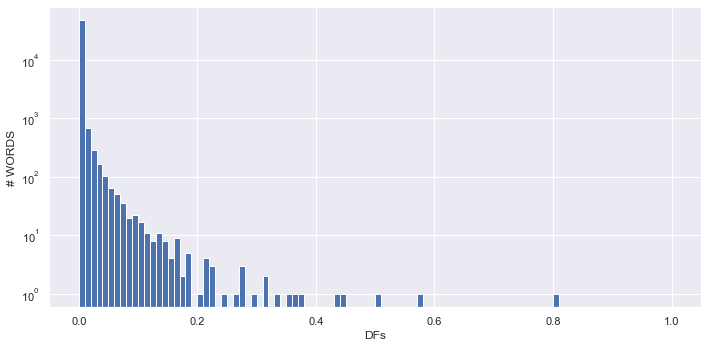

In [17]:
from collections import Counter

#calculate words frequencies per document
word_frequencies = [Counter(article.split()) for article in articlesList]

#calculate document frequency
document_frequencies = Counter()

for word_freq_list in word_frequencies:
    document_frequencies.update(word_freq_list.keys())

dfs = np.array(list(document_frequencies.values()))/len(articlesList)
plt.hist(dfs, bins = 100, range=[0, 1])
plt.xlabel("DFs")
plt.yscale("log")
plt.ylabel("# WORDS")
plt.tight_layout()

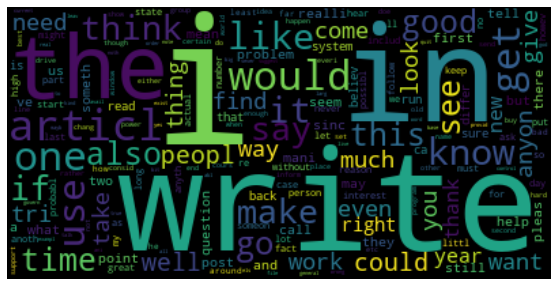

In [18]:
from wordcloud import WordCloud
word_cloud = WordCloud().generate_from_frequencies(document_frequencies)
print(word_cloud)
plt.figure()
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Del histograma anterior se desprenden dos conclusiones.  

En primer lugar, la mayor parte de las palabras presenta una *document frequency* menor a 0.1. A fin de analizar cuales son las palabras que aparecen una mayor cantidad de veces, se realizó una "nube" de palabras y se observó que dichas palabras no son de interés para el modelo ya que se trata de palabras muy genéricas, como "write", "would", "in", "the". Estas palabras no aportan información acerca de las categorías de los textos analizados y simplemente generarían ruido y costo computacional. Por esta razón, se seleccionó un max_df de 0.1.  

En segundo lugar, en el histograma se puede verificar que existe una cantidad muy grande de palabras cuya *document frequency* es extremendamente baja (cercana a 0). Estas palabras, al aparecer en pocos artículos, no brindan información relevante sobre la categoría a la que pertenece. Para filtrar estas palabras se fijó un min_df de 5. Es decir, todas las palabras que aparezcan en menos de 5 artículos serán ignoradas.


Para un uso eficiente de la memoria, la herramienta CountVectorizer devuelve una matriz dispersa. Como en este caso no contamos con una cantidad extremadamente grande de datos, es beneficioso convertir dicha matriz en una matriz común con la función ".toarray()" y así trabajar normalmente con los valores obtenidos..
  
Sin embargo, al correr reiteradamente este programa es posible que no quede lugar en la memoria. En tal caso, es recomendable ejecutar "%reset" (como se realiza en el comentario de la próxima celda) para limpiar las variables que hayan quedado guardadas y volver a correr el programa posteriormente.

In [19]:
# %reset
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_df = 0.1, min_df = 5)
vectorizedData = count_vectorizer.fit_transform(articlesList)
vectorizedDataArray = vectorizedData.toarray() #sparsed -> expanded matrix
vectorizedDataArray.shape

(11314, 12594)

In [20]:
# Se imprime el vocabulario resultante en un txt con el fin de analizarlo visualmente.
with open('word_list.txt', 'w') as fp:
    for word in count_vectorizer.get_feature_names():
        fp.write(word + "\n")

---
## Entrenamiento del modelo.
### Clasificador Naive Bayes
Los clasificadores Naive Bayes multinomiales aprovechan la teoría de la probabilidad y el Teorema de Bayes para predecir a que clase corresponde una entrada; en el caso estudiado se predice a que categoría corresponde un texto ingresado. Son probabilísticos, lo que significa que calculan la probabilidad de cada clase dada la entrada y eligen la clase con la probabilidad más alta. El modo en que obtienen estas probabilidades es utilizando el Teorema de Bayes.  

De esta forma, los clasificadores calculan la probabilidad de cada clase dada una entrada x de acuerdo a la siguiente fórmula, donde 'x' es la entrada y 'c' la clase de salida:  

\begin{equation}
P(c|x) = \frac{P(x|c)\cdot P(c)}{P(x)}
\end{equation}

En el caso de estudio 'x' es un artículo que cuenta con una serie de palabras y 'c' es una categoría de las 20 posibles.

Como *terminología*, se denomina a:
* $P(c|x)$ como ***probabilidad a posteriori***. Representa la probabilidad de que dada una entrada, dicha entrada corresponda a la clase 'c'.
* $P(x|c)$ como ***likelihood***. Representa la probabilidad de que se de una entrada 'x' dado que se conoce la clase estudiada.
* $P(c)$ como ***probabilidad a priori*** de cada clase. Representa la probabilidad de que una entrada corresponda a dicha clase sin conocer otros parámetros.  

Cabe destacar que como las probabilidades a posteriori obtenidas son únicamente comparadas entre ellas para determinar la categoría de una entrada y que la probabilidad $P(x)$ no depende de la categoría, este término puede no ser cálculado y el resultado será el mismo. Así, se compara entre cada categoría al numerador de la fórmula expresada anteriormente.

Se debe tener en cuenta que generalmente al realizar un análisis de textos, los likelihoods resultan muy pequeños y esto puede generar ciertos problemas al trabajar con ellos. Para solucionar este conflicto, se aprovecha el hecho de que la función logarítmica es monótona creciente y que números de baja magnitud se traducen en números de mayor valor -y negativos-. Por estos factores, es conveniente trabajar con ***log-likelihoods*** (salida de $log(likelihood)$). Las probabilidades a posteriori cambiarán pero como se mencionó la monotonía creciente del $log$ hace que las comparaciones sigan siendo válidas.

## Smoothing Laplaciano
La matríz dispersa que resulta de la salida del count vectorizer que se utiliza para modelar la cantidad de palabras que tiene cada artículo, por su naturaleza tiene muchos ceros. Por ende puede ocurrir, sobretodo en los casos en los que el vocabulario es extenso, que al calcular la probabilidad de cada palabra para cada categoría, que existan palabras para ciertas categorías que tengan probabilidad de ocurrencia igual a cero (o -infinito en el caso de utilizar probabilidades logarítmicas). Esto plantea el problema de que al utilizar el clasificador con este modelo puede ocurrir que en el artículo que se está evaluando aparezcan palabras con probabilidad de ocurrencia igual a cero para esa categoría, y por las características del modelo de probabilidad bayesiano mediante naive bayes, al tener una palabra con probabilidad de ocurrencias igual a cero en el artículo a clasificar, se tiene el problema de que independientemente de la ocurrencia y probabilidad de las demas palabras que conforman el artículo, la probabilidad final será cero. Esto es algo poco pragmatico y realista ya que el problema en muchos casos es que en realidad, el set de datos es en efecto pequeño, por lo que para evitar que esto ocurra se utiliza el Smoothing Laplaciano.

Con el Smoothing Laplaciano lo que se hace es sumar un valor alpha a cada una de las ocurrencias de palabras (que conforman el vocabulario) en esa categoría. De esta manera todas las palabras del vocabulario, aparezcan o no en la categoría tedrán una probabilidad superior a cero que será mayor o menor segun la cantidad de apariciones de la palabra en la categoría, paliando asi el problema antes mencionado. 

Por lo anterior se ve que el uso de smoothing laplaciano puede ser muy provechoso para evitar posibles problemas.

Para analizar el problema matemáticamente, supongamos que tengamos un vector $\vec{N}$ con el tamaño del número de palabras que conforman el vocabulario, en donde se almacena la lista de veces en las que ocurre cada palabra i para la categoría "A" dada.

Entonces la sumatoria de todos los elementos $n_{i}$ que conforman el $\vec{N}$ da como resultado N.

La cantidad posible de categorías en las que hay que clasificar es K.

El alpha se elige arbitrariamente con valor mayor a cero, tipicamente igual a 1.

De esta manera, con la siguiente fórmula, seríamos capaces de calcular la probabilidad de ocurrencia de cada una de las palabras del vocabulario dentro de la categoría seleccionada. 

$$\frac{n_{i}+\alpha}{N + k\cdot \alpha}$$

En muchos casos se implementa el logarítmo de esta probabilidad, debido a que usualmente se generan valores muy pequeños por lo que el logarítmo permite llevar los valores muy pequeños a valores mas facilmente utilizables.

In [21]:
def train_model(vectorized_data_arr):
    """
    Entrena al modelo dado un arreglo de datos vectorizados.
    Devuelve: 
        *(1)   Array de probabilidades (logarítmicas) de ocurrencia de las palabras dadas las distintas categorías.
        *(2)   Array de probabilidades (logarítmicas) a priori de las distintas categorías.
    Para calcular los log-likelihoods se debe realizar, para cada posible categoría, el producto escalar entre (1) y la entrada vectorizada y posteriormente sumar (2). 
    """
    N_cat = len(twenty_train.target_names)
    N_arts = vectorized_data_arr.shape[0]
    N_words = vectorized_data_arr.shape[1]
    log_probs_of_words_given_cat = list()
    cats_priors_log_probs = list()
    alfa = 1

    for target_name in twenty_train.target_names:
        #Se buscan los artículos que pertecen a la categoría actual. Devuelve array de bools.
        article_belongs_to_category = np.asarray(np_target_names[np_target] == target_name)
        #Se filtran los artículos que no pertencen a la categoría actual.
        articles_of_this_category = vectorized_data_arr[article_belongs_to_category]
        #Se calcula la cantidad de ocurrencias de las distintas palabras (+alfa de smoothing laplaciano) en la categoría actual.
        word_ocurrencies_in_category = articles_of_this_category.sum(axis = 0) + alfa
        #Se calcula la probabilidad (logarítmica) de ocurrencia de las palabras dada la categoría actual. Ejemplo p("raqueta"|"deportes").
        log_probs_of_words_given_cat.append(np.log(word_ocurrencies_in_category/sum(word_ocurrencies_in_category)))
        #Se calcula la probabilidad (logarítmica) a priori de la categoría actual.
        cats_priors_log_probs.append(np.log(article_belongs_to_category.sum()/N_arts))

    return log_probs_of_words_given_cat, cats_priors_log_probs


In [22]:
log_probs_of_words_given_cat, cats_priors_log_probs = train_model(vectorizedDataArray);

---
## Testeo del modelo.
### Métricas
Existen distintas métricas con las cuales se puede caracterizar un modelo.  
Entre ellas se encuentran:
* Exactitud (accuracy): relación entre las predicciones correctas sobre la cantidad total de predicciones realizadas.
* Log Loss: penaliza las predicciones incorrectas.
* Exactitud de la Matriz de Confusión: útil para clasificaciones binarias. Relación entre verdaderos positivos más verdaderos negativos dividido posteriormente por la cantidad total de predicciones realizadas.
* AUC: con el que se calculan la especificidad y la sensibilidad para clasificaciones binarias.
* F1 Score: Media armónica entre especificidad y sensibilidad.

Analizando las distintas métricas, tanto la exactitud como el log loss se podrían aplicar al problema ya que es posible usarlas para categorización no binomial. Sin embargo, el Log Loss es más utilizado en casos donde una predicción incorrecta conlleva un alto costo, a diferencia de lo que sucede en este caso. En el presente problema, como las distintas categorías presentan una probabilidad a priori similar, la exactitud resulta una métrica favorable.  

Por estas razones, decidimos utilizar a la ***exactitud*** como la métrica del modelo.


### Prueba con set de Train.

In [23]:
def test_model(data_set, verification_set, log_probs_of_words_given_cat, cats_priors_log_probs):
    """
    Realiza una prueba del modelo entrenado. 
    Parámetros:
        1. data_set: Set de datos sobre los cuales se iterará para calcular la métrica del modelo.
        2. verification_set: Set de datos con los cuales se verificarán los resultado que se predijeron con el data_set.
        3. log_probs_of_words_given_cat: Array de probabilidades (logarítmicas) de ocurrencia de las palabras dadas las distintas categorías.
        4. cats_priors_log_probs: Array de probabilidades (logarítmicas) a priori de las distintas categorías.
        Los parámetros 3 y 4 son los parámetros devueltos por la función "train_model".
    Devuelve:
        * Accuracy del modelo.
    """
    predictionOk = 0
    n_arts = data_set.shape[0]
    for n_art in range(n_arts):
        maxIdx = -1
        naive_cat_max_prob = -float('inf')
        for i in range(len(verification_set.target_names)):
            naive_cat_prob = np.dot((data_set[n_art]),log_probs_of_words_given_cat[i])+cats_priors_log_probs[i]
            if (naive_cat_prob > naive_cat_max_prob):
                naive_cat_max_prob = naive_cat_prob
                maxIdx = i
        if(maxIdx == verification_set.target[n_art]):
            predictionOk += 1
    acc = predictionOk/n_arts
    return acc

In [24]:
acc_train = test_model(vectorizedDataArray, twenty_train, log_probs_of_words_given_cat, cats_priors_log_probs)
print("Accuracy Train: " + str(acc_train))

Accuracy Train: 0.8607035531200283


### Prueba con set de Test.

In [8]:
#Preprocesamiento del set de Test.
filteredTestArts = pre_process_data(twenty_test.data)

Procesado: 99%


In [23]:
#Se guarda el resultado del preprocesamiento en un archivo mediante la librería Pickle.
save_preprocessed_data('art_filt_test.pkl', filteredTestArts)

In [5]:
#Se lee el resultado del preprocesamiento guardado en un archivo mediante la librería Pickle.
testArticlesList = load_preprocessed_data('art_filt_test.pkl')
#Se verifica que los artículos hayan sido obtenidos correctamente.
print(len(testArticlesList))
print(testArticlesList[0])

7532
i littl confus model bonnevill i hear le se lse sse ssei could someon tell differ far featur perform i also curious know book valu prefer model and much less book valu usual get in word much demand time year i hear earli summer best time buy


In [25]:
# Vectorización del set de test.
testData = count_vectorizer.transform(testArticlesList)
testDataArray = testData.toarray()
print(testData.shape)

(7532, 12594)


### Obtención del accuracy del modelo.

In [26]:
acc_test = test_model(testDataArray, twenty_test, log_probs_of_words_given_cat, cats_priors_log_probs)
print("Accuracy Test: " + str(acc_test))

Accuracy Test: 0.7308815719596389


---
## Con TFIDF
El vectorizador CountVectorizer presenta una desventaja la cual es su incapacidad para identificar las palabras más y menos importantes para el análisis. Para solucionarlo, a continuación se evaluará el desempeño del modelo utilizando el vectorizador TfidfVectorizer.  

El TF-IDF (Term Frequency(TF) — Inverse Dense Frequency(IDF)) es una medida estadística que evalúa la relevancia de una palabra en un documento de una colección de documentos. Para ello se multiplican dos factores: el número de veces que aparece una palabra en un documento (TF) y la frecuencia inversa de la palabra en un conjunto de documentos (IDF). TF-IDF es más efectivo que los vectorizadores de conteo porque no sólo se centra en la frecuencia de las palabras presentes en el documento, sino que también proporciona la importancia de las palabras.  

La forma de calcular el TF-IDF es la siguiente:  
\begin{equation}
w_{i,j} = tf_{i,j} \cdot  log(\frac{N}{df_{i,j}})
\end{equation}
Donde:
* i representa la palabra analizada.
* j representa el documento analizado.
* $w_{i,j}$ representa el tfidf o peso de la palabra i en el documento j.
* $tf_{i,j}$ representa la cantidad de ocurrencias de la palabra i en el documento j.
* $df_{i,j}$ representa la cantidad de documentos que presentan la palabra i.
* N representa el número total de documentos.  

El TFIDF se basa en la lógica de que tanto las palabras demasiado abundantes como las demasiado raras no son estadísticamente importantes para encontrar un patrón. El factor logarítmico del TFIDF penaliza matemáticamente las palabras que son demasiado abundantes o demasiado raras otorgándoles puntuaciones TFIDF bajas. Por ejemplo, si una palabra aparece en un solo documento, el IDF valdrá $log(N)$. En cambio, si una palabra aparece en todos los documentos, el IDF responderá como $log(\frac{N}{N}) = log(1) = 0$.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.1, min_df = 5)
vectorizedDataTfidf = tfidf_vectorizer.fit_transform(articlesList)
vectorizedDataTfidfArray = vectorizedDataTfidf.toarray() #sparsed -> expanded matrix
vectorizedDataTfidfArray.shape


testDataTfidf = tfidf_vectorizer.transform(testArticlesList)
testDataArrayTfidf = testDataTfidf.toarray()

In [28]:
log_probs_of_words_given_cat_tfidf, cats_priors_log_probs_tfidf = train_model(vectorizedDataTfidfArray)
acc_test_tfidf = test_model(testDataArrayTfidf, twenty_test, log_probs_of_words_given_cat_tfidf, cats_priors_log_probs_tfidf)
print("Accuracy Test with TFIDF: " + str(acc_test_tfidf))

Accuracy Test with TFIDF: 0.7588953797132236


A continuación se resumen los resultados obtenidos para el modelo utilizando CountVectorizer y TfidfVectorizer.

|   Vectorizador  | Accuracy |
|:---------------:|:--------:|
| CountVectorizer |   0.73   |
| TfidfVectorizer |   0.76   |